# Learning to trace geometrical paths for faster Ray Tracing

TODO

In [1]:
from collections.abc import Iterator
from typing import Any, Optional

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, PRNGKeyArray, Shaped, UInt, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Problem definition

The goal of our model is to generate all the paths, of a given order, between TX and RX in a 2D scene.

Here, the

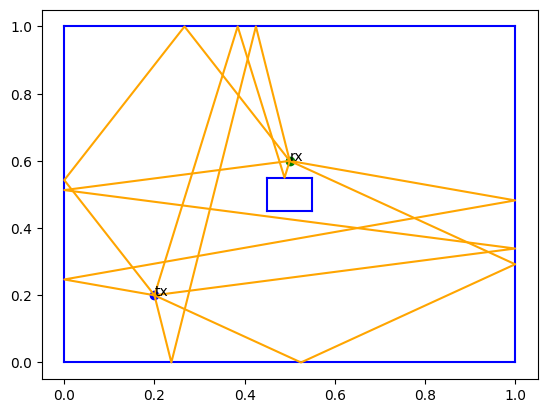

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(
    min_order=order, max_order=order, approx=False
):
    path.plot(ax)

plt.show()

## Training data generation

In [3]:
key = jax.random.PRNGKey(12345)
key, key_example_scene = jax.random.split(key, 2)


def random_scenes(
    *,
    key: PRNGKeyArray,
    min_ratio: float = 0.25,
    max_ratio: float = 0.75,
    min_num_walls: int = 2,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.uint32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=0.0, maxval=2 * jnp.pi
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    order: int, **kwargs: Any
) -> Iterator[tuple[Float[Array, "2+num_walls*2 2"], UInt[Array, "num_paths {order}"]]]:
    for scene, points in random_scenes(**kwargs):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        # Handle edge case with no path
        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.uint32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.uint32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

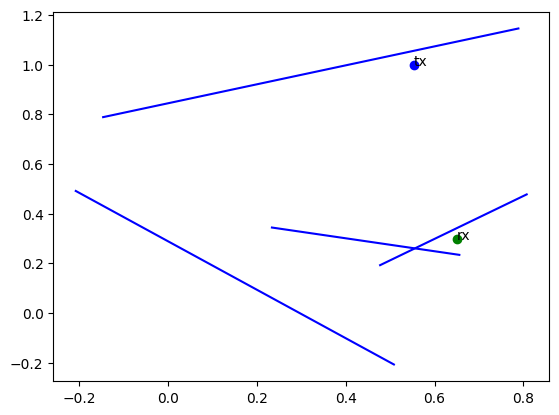

In [4]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(
    min_order=order, max_order=order, approx=False
):
    path.plot(ax)

plt.show()

In [5]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)
key_train_samples, key_test_samples = jax.random.split(key_samples, 2)

train_samples = samples(order=order, key=key_train_samples)
test_samples = samples(order=order, key=key_test_samples)

In [6]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def row_in_matrix(
    row: Shaped[Array, " num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " "]:
    bool_ = jax.vmap(jnp.equal, in_axes=(None, 0))(row, matrix)
    return jnp.any(jnp.all(bool_, axis=1), axis=0)


@jax.jit
@jaxtyped(typechecker=typechecker)
def rows_in_matrix(
    rows: Shaped[Array, "batch num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " batch"]:
    return jax.vmap(row_in_matrix, in_axes=(0, None))(rows, matrix)


@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidates: UInt[Array, "batch order"],
    confidences: Float[Array, " batch"],
    true_path_candidates: UInt[Array, "num_paths order"],
) -> Float[Array, " "]:
    """
    The reward works as follows:

    0. Paths are generated in batches, because for a given scene we predict 'batch' path candidates
    1. We check, for each predicted path, if it is part of the set of true path candidates
    2. We create a mask to only count unique path candidates "once"
    3. We reward each valid (= in set) path candidate with its 'confidence' and we penalize
       each invalid path candidate with its 'confidence' (weighted down).
    """
    # 1. Check if predicted path candidates are in the set of true path candidates
    pred_in_true = rows_in_matrix(pred_path_candidates, true_path_candidates)

    # 2. Next, check for duplicate
    values, index = jnp.unique(
        pred_path_candidates,
        return_index=True,
        size=confidences.size,
        fill_value=-1,
        axis=0,
    )
    arange = jnp.arange(pred_path_candidates.shape[0], dtype=index.dtype)
    index = jnp.where(jnp.all(values != -1, axis=1), index, -1)
    unique_mask = jnp.isin(arange, index)

    # 3. We only reward each valid path candidate once!

    # Suggestion: maybe I just normalize the reward by the number of paths to avoid having a too large penatly
    # and thus favoring a 0 confidence...

    return jnp.sum(
        jnp.where(
            pred_in_true,  # valid path candidates
            jnp.where(
                unique_mask,
                confidences,  # sum(confidences) for unique valid path candidates
                0,  # duplicate valid path candidates do not reward any point
            ),
            -confidences,  # sum(-confidences) for all invalid path candidates
        )
    )

In [7]:
# Example to show how the reward function works
pred_path_candidates = jnp.array(
    [[0, 1], [2, 3], [1, 2], [2, 3], [0, 1], [4, 5]], dtype=jnp.uint32
)

confidences = jnp.array([1.0, 1.0, 0.5, 1.0, 0.0, 0.0])

true_path_candidates = jnp.array([[0, 1], [2, 3]], dtype=jnp.uint32)

with jax.disable_jit():
    r = reward(pred_path_candidates, confidences, true_path_candidates)
    print(r)

1.5


# Model definition

In [8]:
class Model(eqx.Module):
    # Hyperparameters
    order: int
    """The order of the path(s)."""
    hidden_size: int = eqx.field(static=True)
    """The hidden size of the GRU cell."""
    # Layers
    phi: eqx.nn.MLP
    """MLP that is applied to each object in parallel and returns unnormalized log probabilities."""
    dropout: eqx.nn.Dropout
    """Dropout layer to randomly zero some probabilities during training."""
    cell: eqx.nn.GRUCell
    """Recurrent cell."""
    state_2_confidence: eqx.nn.MLP
    """Layer that maps the final state of the recurrent cell to some confidence [0, 1]."""

    def __init__(
        self,
        # Hyperparameters
        order: int = 1,
        hidden_size: int = 500,
        *,
        key: PRNGKeyArray,
    ):
        if order < 0:
            raise ValueError(f"Order must be greater or equal to 0, got {order}.")

        key1, key2, key3 = jax.random.split(key, 3)

        self.order = order
        self.hidden_size = hidden_size
        self.phi = eqx.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,
            key=key1,
        )
        self.dropout = eqx.nn.Dropout()
        self.cell = eqx.nn.GRUCell(
            input_size=1,
            hidden_size=hidden_size,
            key=key2,
        )
        self.state_2_confidence = eqx.nn.MLP(
            in_size=hidden_size,
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jax.nn.sigmoid,
            key=key3,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def init_state(self) -> Float[Array, "{self.hidden_size}"]:
        return jnp.zeros(self.hidden_size)

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        xys: Float[Array, "two_plus_num_walls_times_two 2"],
        prev_state: Float[Array, "{self.hidden_size}"],
        *,
        key: Optional[PRNGKeyArray] = None,
    ) -> tuple[
        UInt[Array, "{self.order}"],
        Float[Array, " "],
        Float[Array, "{self.hidden_size}"],
    ]:
        assert xys.shape[0] >= 2, "Scene must at least have two points: tx and rx."

        # [2]
        # We currently do not use TX and RX (hence the 'noqa'), to be improved.
        tx = xys[0, :]  # noqa: F841
        rx = xys[1, :]  # noqa: F841

        # [num_walls, 2x2]
        walls = xys[2:, :].reshape(-1, 4)
        num_walls = walls.shape[0]

        # Handle empty scene
        if walls.size == 0:
            if self.order == 0:
                return (
                    jnp.empty(0, dtype=jnp.uint32),
                    jnp.array(1.0),
                    prev_state,
                )  # One path candidate of size 0, but it does not make sense to use this model for order < 1
            else:
                return (
                    jnp.empty(self.order, dtype=jnp.uint32),
                    jnp.array(0.0),
                    prev_state,
                )  # Zero path candidate of size order, so we return a 0 confidence

        Carry = tuple[Float[Array, " hidden_size"], Float[Array, " num_walls"]]
        Index = UInt[Array, " "]

        @jaxtyped(typechecker=typechecker)
        def scan_fn(carry: Carry, key: PRNGKeyArray) -> tuple[Carry, Index]:
            state, prev_probs = carry
            key_categorical, key_dropout = jax.random.split(key, 2)
            probs = jax.vmap(self.phi)(walls)
            probs = probs * (1 - prev_probs)
            probs = self.dropout(probs, key=key_dropout)
            index = jax.random.categorical(key=key_categorical, logits=probs)

            state = self.cell(jnp.atleast_1d(index), state)

            return (state, prev_probs), index.astype(jnp.uint32)

        if prev_state is not None:
            init_state = prev_state
        else:
            init_state = jnp.zeros(self.hidden_size)

        init = (init_state, jnp.zeros(num_walls))

        (final_state, _), path_candidate = jax.lax.scan(
            scan_fn, init, xs=jax.random.split(key, self.order)
        )

        confidence = self.state_2_confidence(final_state)

        return path_candidate, confidence, final_state

## Loss function definition

In [9]:
@jaxtyped(typechecker=typechecker)
def loss(
    model: Model,
    xys: Float[Array, "two_plus_num_walls_times_two 2"],
    true_path_candidates: UInt[Array, "num_paths order"],
    batch: int = 20,
    plot: bool = False,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.
    """

    @jaxtyped(typechecker=typechecker)
    def scan_fn(
        state: Float[Array, " hidden_size"], key: PRNGKeyArray
    ) -> tuple[
        Float[Array, " hidden_size"], tuple[UInt[Array, " order"], Float[Array, " "]]
    ]:
        pred_path_candidate, confidence, state = model(xys, state, key=key)

        return state, (pred_path_candidate, confidence)

    init_state = model.init_state()

    _, (pred_path_candidates, confidences) = jax.lax.scan(
        scan_fn, init_state, xs=jax.random.split(key, batch)
    )

    if plot:
        order = model.order
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)

        for _, _, path, _ in scene.all_valid_paths(
            min_order=order, max_order=order, approx=False
        ):
            path.plot(ax, color="orange")

        if len(walls) > 0:
            for pred_path_candidate, confidence in zip(
                pred_path_candidates, confidences
            ):
                print(f"{pred_path_candidate = }, {confidence = }")
                objects = [scene.objects[i] for i in pred_path_candidate]
                ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                    ax, linestyle="--", alpha=float(confidence), color="red"
                )

    return -reward(pred_path_candidates, confidences, true_path_candidates)

In [10]:
training_model = Model(order=order, key=key_model)
optim = optax.adam(learning_rate=1e-4)

pred_path_candidate = Array([1, 1], dtype=uint32), confidence = Array(0.49524996, dtype=float32)
pred_path_candidate = Array([1, 2], dtype=uint32), confidence = Array(0.4953221, dtype=float32)
pred_path_candidate = Array([3, 0], dtype=uint32), confidence = Array(0.49523866, dtype=float32)
pred_path_candidate = Array([0, 2], dtype=uint32), confidence = Array(0.49524862, dtype=float32)
pred_path_candidate = Array([0, 2], dtype=uint32), confidence = Array(0.49525556, dtype=float32)
pred_path_candidate = Array([2, 1], dtype=uint32), confidence = Array(0.49525282, dtype=float32)
pred_path_candidate = Array([3, 3], dtype=uint32), confidence = Array(0.49541697, dtype=float32)
pred_path_candidate = Array([1, 2], dtype=uint32), confidence = Array(0.4952735, dtype=float32)
pred_path_candidate = Array([3, 1], dtype=uint32), confidence = Array(0.49524164, dtype=float32)
pred_path_candidate = Array([2, 3], dtype=uint32), confidence = Array(0.49535635, dtype=float32)
pred_path_candidate = Array([2, 

Array(9.905124, dtype=float32)

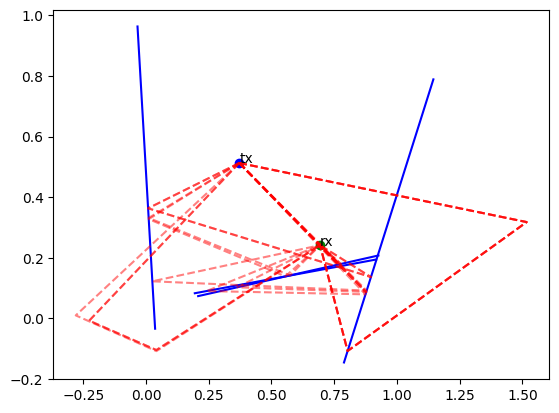

In [11]:
loss(training_model, *next(train_samples), plot=True, key=key)  # Untrained model

In [12]:
def train(
    model: Model,
    train_samples: Iterator,
    test_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 10_000,
    print_every: int = 1_000,
    num_test_samples: int = 100,
    *,
    key: PRNGKeyArray,
) -> tuple[Model, Float[Array, "{steps}"]]:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: Model,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    train_losses = []

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            if (step % print_every) == 0 or (step == steps - 1):
                bar.set_description(f"train_loss = {float(train_loss):.1f}")
            train_losses.append(train_loss)

    return model, jnp.array(train_losses)

  0%|          | 0/10000 [00:00<?, ? steps/s]

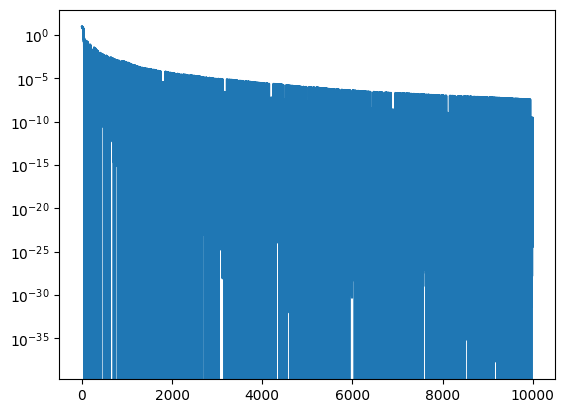

In [13]:
training_model, losses = train(
    training_model, train_samples, test_samples, optim, key=key_train
)
inference_model = eqx.nn.inference_mode(training_model)

plt.semilogy(losses)

pred_path_candidate = Array([0, 0], dtype=uint32), confidence = Array(3.771484e-08, dtype=float32)
pred_path_candidate = Array([0, 0], dtype=uint32), confidence = Array(1.6114744e-16, dtype=float32)
pred_path_candidate = Array([0, 0], dtype=uint32), confidence = Array(4.033932e-29, dtype=float32)
pred_path_candidate = Array([0, 1], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([0, 1], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([1, 0], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([1, 1], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([0, 1], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([1, 0], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([1, 0], dtype=uint32), confidence = Array(0., dtype=float32)
pred_path_candidate = Array([0, 0], dtype=uint32), confidence = Array(0., dtype

Array(3.771484e-08, dtype=float32)

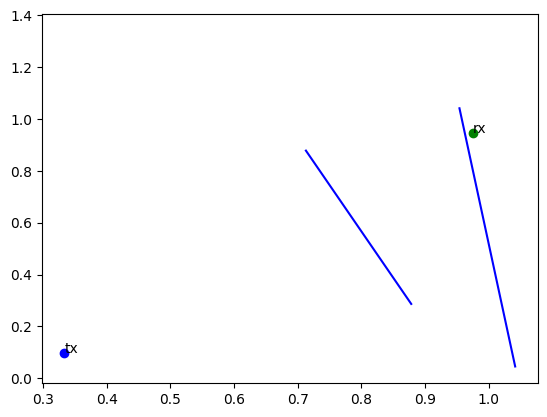

In [14]:
key, key_test_inference = jax.random.split(key, 2)

loss(inference_model, *next(test_samples), plot=True, key=key_test_inference)